# IY011 Contrastive Learning: Model Training
Randomly pick pairs of samples from the dataset, randomly assign labels to each, and train a model to distinguish them

In [1]:
import os
import subprocess
import glob
import tempfile
from pathlib import Path
import numpy as np
import pandas as pd
import time
# plotting 
import matplotlib.pyplot as plt
from visualisation.plots import plot_mRNA_dist, plot_mRNA_trajectory
# ml
import torch, itertools
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from models.transformer import TransformerClassifier
from training.eval import evaluate_model
from training.train import train_model 

# data handling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Build groups
from utils.data_processing import build_groups

import wandb
%load_ext autoreload
%autoreload 2  

In [2]:
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data")
RESULTS_PATH = DATA_ROOT / "IY011_simulation_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
# TRAJ_PATH = [DATA_ROOT / f"mRNA_trajectories_mu{row['mu_target']:.3f}_cv{row['cv_target']:.3f}_tac{row['t_ac_target']:.3f}.csv" for idx, row in df_params.iterrows()] # the trajectories 
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]

# extract meta data
parameter_sets = [{
    'sigma_b': row['sigma_b'],
    'sigma_u': row['sigma_u'],
    'rho': row['rho'],
    'd': row['d'],
    'label': 0
} for idx, row in df_params.iterrows()]
time_points = np.arange(0, 3000, 1.0)
size = 1000

In [3]:
num_traj = 500
NUM_GROUPS = 8
groups = build_groups(TRAJ_NPZ_PATH, num_groups=NUM_GROUPS, num_traj=num_traj) # list of tuples (X, y)

Building negative groups: 100%|██████████| 4/4 [00:00<00:00, 173.68it/s]


## Data Prep

In [4]:
def data_prep(groups, batch_size):
    # Stacked groups -> individual trajectory samples
    X_samples = []
    y_samples = []
    for Xg, yg in groups:          # Xg shape (seq_len, K)
        L, K = Xg.shape
        for k in range(K):
            X_samples.append(Xg[:, k:k+1])  # (seq_len, 1)
            y_samples.append(yg)            # or some other per-trajectory label
    X_samples = np.stack(X_samples, 0)      # (N_samples, seq_len, 1)
    y_samples = np.array(y_samples)
    print(f'X_samples shape: {X_samples.shape}, y_samples shape: {y_samples.shape}')

    # with the stacked samples
    X_train, X_test, y_train, y_test = train_test_split(
        X_samples, y_samples, test_size=0.2, random_state=42, stratify=y_samples
    )
    X_train, X_val,  y_train, y_val  = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print("Data preparation:")
    print(f"  Train groups: {len(y_train)}, Val groups: {len(y_val)}, Test groups: {len(y_test)}")
    # === Standardise features (across time*batch, per-channel) ===
    scaler = StandardScaler()

    # Reshape 3D data to 2D for scaling
    original_shape_train = X_train.shape
    original_shape_val = X_val.shape
    original_shape_test = X_test.shape

    # Reshape to 2D: (batch * seq_len, features)
    X_train_2d = X_train.reshape(-1, X_train.shape[-1])
    X_val_2d = X_val.reshape(-1, X_val.shape[-1])
    X_test_2d = X_test.reshape(-1, X_test.shape[-1])

    # Scale the data
    X_train_2d = scaler.fit_transform(X_train_2d)
    X_val_2d = scaler.transform(X_val_2d)
    X_test_2d = scaler.transform(X_test_2d)

    # Reshape back to 3D
    X_train = X_train_2d.reshape(original_shape_train)
    X_val = X_val_2d.reshape(original_shape_val)
    X_test = X_test_2d.reshape(original_shape_test)

    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    print("X_test shape:", X_test.shape)

    # === Convert to tensors and loaders ===
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,   dtype=torch.long)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,  dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
    val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # check the data loaders
    for X_batch, y_batch in train_loader:
        print(X_batch.shape, y_batch.shape)
        break 
    
    return train_loader, val_loader, test_loader

## Transformer Model Eval
start by defining some model & training hyperparameters

In [5]:
# === Dataloader hyperparams & data prep ===
batch_size = 64
train_loader, val_loader, test_loader = data_prep(groups, batch_size)
# === Dataloader hyperparams & data prep ===

X_samples shape: (4000, 1811, 1), y_samples shape: (4000,)
Data preparation:
  Train groups: 2560, Val groups: 640, Test groups: 800
X_train shape: (2560, 1811, 1)
X_val shape: (640, 1811, 1)
X_test shape: (800, 1811, 1)
torch.Size([64, 1811, 1]) torch.Size([64])


In [6]:
# === Model hyperparams ===
input_size = 1
num_classes = 2
d_model=64
nhead=4
num_layers=2
dropout=0.001
use_conv1d=False 

model = TransformerClassifier(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout, 
    use_conv1d=use_conv1d 
)
# === Model hyperparams ===

# === Training hyperparams ===
epochs = 50
patience = 10
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

### schedulers ### 
# 1. simple scheduler choice
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5) 

# 2. cosine scheduler with warmup, most commonly used for transformer
total_steps = epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)   # 10% warmup (good default)
#  (from huggingface)
from transformers import get_cosine_schedule_with_warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
) 

loss_fn = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip = 1.0
save_path = None
verbose = True

model.to(device)
# === Training hyperparams ===

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TransformerClassifier(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (pe): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.001, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.001, inplace=False)
        (dropout2): Dropout(p=0.001, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.001, inplace=False)
  (head): Linear(in_features=64, out_features=2, bias=True)
)

wandb logging setup: 
1. set `wandb_logging=True` in `train_model` function call to enable logging
2. pass `wandb_config` dictionary to log hyperparameters

In [7]:
# === wandb config (required for tracking within train_model) ===
wandb_config = {
    "entity": "grignard-reagent",
    "project": "IY011-contrastive-learning",
    "name": f"groups_{NUM_GROUPS}_traj_{num_traj}_batch_size_{batch_size}", # change this to what you want
    "dataset": DATA_ROOT.name,
    "batch_size": batch_size,
    "input_size": input_size,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "num_classes": num_classes,
    "dropout": dropout,
    "use_conv1d": use_conv1d,
    "epochs": epochs,
    "patience": patience,
    "lr": lr,
    "optimizer": type(optimizer).__name__,
    "scheduler": type(scheduler).__name__,
    "loss_fn": type(loss_fn).__name__,
    "model": type(model).__name__,
    "batch_size": train_loader.batch_size,
    "num_traj_per_group": num_traj,
    "num_groups": NUM_GROUPS,
}
# === wandb config === 

Using modularised code for training and eval

In [8]:
history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    patience=patience,
    lr=lr,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    grad_clip=grad_clip,
    save_path=save_path,
    verbose=verbose,
    wandb_logging=True, # this enables wandb logging within train_model
    wandb_config=wandb_config, # pass the config dictionary
)

wandb: Currently logged in as: grignardreagent (grignard-reagent) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training...
Epoch [1/50] | train_loss 0.8013 | train_acc 0.5000 | val_loss 0.8026 | val_acc 0.5000
Epoch [2/50] | train_loss 0.6843 | train_acc 0.6098 | val_loss 0.6027 | val_acc 0.7453
Epoch [3/50] | train_loss 0.5113 | train_acc 0.7762 | val_loss 0.4728 | val_acc 0.7844
Epoch [4/50] | train_loss 0.4324 | train_acc 0.8273 | val_loss 0.4231 | val_acc 0.8203
Epoch [5/50] | train_loss 0.3950 | train_acc 0.8516 | val_loss 0.3903 | val_acc 0.8516
No improvement (1/10).
Epoch [6/50] | train_loss 0.3726 | train_acc 0.8594 | val_loss 0.3739 | val_acc 0.8469
No improvement (2/10).
Epoch [7/50] | train_loss 0.3654 | train_acc 0.8598 | val_loss 0.3628 | val_acc 0.8438
Epoch [8/50] | train_loss 0.3524 | train_acc 0.8586 | val_loss 0.3547 | val_acc 0.8547
No improvement (1/10).
Epoch [9/50] | train_loss 0.3322 | train_acc 0.8598 | val_loss 0.3182 | val_acc 0.8516
Epoch [10/50] | train_loss 0.3189 | train_acc 0.8562 | val_loss 0.2837 | val_acc 0.8562
Epoch [11/50] | train_loss 0.2750 | tra

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
grad/norm,█▄▃█▆▁▂█▄▇██▄█▇▆████▆▃▆████▃███▇▅▄██▅█▁▇
lr,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/acc,▁▃▅▆▆▆▆▆▆▆▇▇▇▇▇█████████████████████████
train/loss,█▇▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▅▅▆▆▆▆▆▆▆▇▇▇▇▇█▇██████████████████▇████
val/loss,█▆▅▄▄▄▄▄▃▄▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▂▁▄▂▁▁▁
best_val_acc,0.9875
epoch,50
grad/norm,0.85196
lr,0.0025


Training complete.


In [9]:
# evaluate on test set
test_loss, test_acc = evaluate_model(
    model,
    test_loader,
    loss_fn,
    device,
)

Test — loss: 0.13 | acc: 0.96


In [10]:
# predict probabilities on test set
from training.eval import predict_proba, _compute_probabilities
probs, targets = predict_proba(model, test_loader, loss_fn, device)

In [11]:
model.eval()
all_probs = []
all_targets = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)                               # raw logits
        probs = _compute_probabilities(logits, loss_fn) # (0,1)

        all_probs.append(probs.cpu())
        all_targets.append(y.cpu())

all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)

print(all_probs[:10])


tensor([9.9954e-01, 9.9870e-01, 1.6338e-06, 9.9996e-01, 9.4523e-01, 9.9556e-01,
        4.1231e-12, 9.9664e-01, 1.2330e-06, 9.9963e-01])


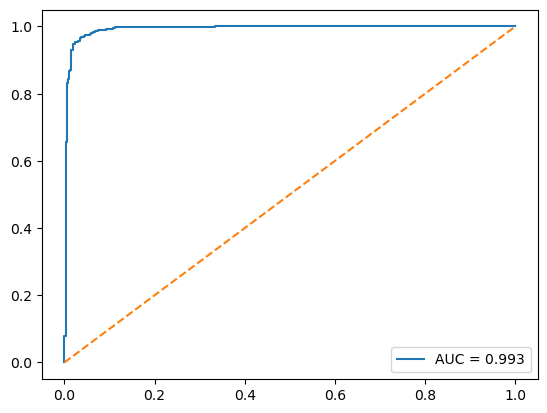

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probs = all_probs.numpy()
targets = all_targets.numpy()

fpr, tpr, _ = roc_curve(targets, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.show()


## SVM Model Benchmark


In [13]:
# Stacked groups -> individual trajectory samples
X_samples = []
y_samples = []
for Xg, yg in groups:          # Xg shape (seq_len, K)
    L, K = Xg.shape
    for k in range(K):
        X_samples.append(Xg[:, k:k+1])  # (seq_len, 1)
        y_samples.append(yg)            # or some other per-trajectory label
X_samples = np.stack(X_samples, 0)      # (N_samples, seq_len, 1)
y_samples = np.array(y_samples)
print(f'X_samples shape: {X_samples.shape}, y_samples shape: {y_samples.shape}')

X_samples shape: (4000, 1811, 1), y_samples shape: (4000,)


In [14]:
# # Train/val/test with stratify on group label
X_train, X_test, y_train, y_test = train_test_split(
    X_samples, y_samples, test_size=0.2, random_state=42, stratify=y_samples
)
X_train, X_val,  y_train, y_val  = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Data preparation:")
print(f"  Train groups: {len(y_train)}, Val groups: {len(y_val)}, Test groups: {len(y_test)}")


Data preparation:
  Train groups: 2560, Val groups: 640, Test groups: 800


In [15]:
# === Standardise features (across time*batch, per-channel) ===
scaler = StandardScaler()

# Reshape 3D data to 2D for scaling
original_shape_train = X_train.shape
original_shape_val = X_val.shape
original_shape_test = X_test.shape

# Reshape to 2D: (batch * seq_len, features)
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_val_2d = X_val.reshape(-1, X_val.shape[-1])
X_test_2d = X_test.reshape(-1, X_test.shape[-1])

# Scale the data
X_train_2d = scaler.fit_transform(X_train_2d)
X_val_2d = scaler.transform(X_val_2d)
X_test_2d = scaler.transform(X_test_2d)

# Reshape back to 3D
X_train = X_train_2d.reshape(original_shape_train)
X_val = X_val_2d.reshape(original_shape_val)
X_test = X_test_2d.reshape(original_shape_test)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (2560, 1811, 1)
X_val shape: (640, 1811, 1)
X_test shape: (800, 1811, 1)


In [16]:
# Torch loaders
batch_size = 64

# === Convert to tensors and loaders ===
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# check the data loaders
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break 

torch.Size([64, 1811, 1]) torch.Size([64])


In [17]:
from classifiers.svm_classifier import svm_classifier

# Flatten the time series data for SVM (reshape from (n_samples, seq_len, features) to (n_samples, seq_len * features))
X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)

svm_accuracy = svm_classifier(
    X_train_svm,
    X_test_svm,
    y_train,
    y_test,
)

=== SVM (RBF Kernel) Classification Accuracy: 0.84 ===


--
# Conclusion
1. The "Old Pipeline" Flaw: Data Flattening
In _1.ipynb (Cell 4), your data_prep function destroyed the contrastive pairs.

``` Python

# From IY011_contrastive_learning_model_training_1.ipynb
def data_prep(groups, batch_size):
    # ...
    for Xg, yg in groups:          # Xg is a group of trajectories (e.g. 500 from File A)
        L, K = Xg.shape
        for k in range(K):
            # PROBLEM: You strip the trajectory away from its partners
            X_samples.append(Xg[:, k:k+1])  
            y_samples.append(yg)            
    # ...
```

What the Model Saw:
- Input: A single trajectory $x$.
- Task: "Is this trajectory from a 'Positive Group' or a 'Negative Group'?"

Why this is impossible (in theory):
- A "Positive Group" (Label 1) contains trajectories from File A.
- A "Negative Group" (Label 0) contains trajectories from File A and File B.
- If the model receives a trajectory $x$ from File A, the correct label could be 1 OR 0. It is ambiguous.

Why it "Converged" (in practice): 

Your build_groups logic (with NUM_GROUPS=8) likely picked disjoint files for the positive and negative sets due to random sampling.

- Group 1 (Pos): File X (Label 1)
- Group 2 (Neg): File Y + File Z (Label 0)
- The model simply learned: "If it looks like File X, say 1. If it looks like File Y or Z, say 0."
- This is just standard classification. It memorized the specific $\mu$ and $CV$ of File X. It did not learn to compare signals. If you gave it a new File D, it would fail completely.

2. Why num_traj mattered in the Old Pipeline
You observed: "the only times the training loop fails to converge was due to when num_traj was set to 2"

- Reason: This was purely a Dataset Size issue.
    - With num_groups=8 and num_traj=2: Total data = 16 samples. Too small to train.
    - With num_groups=8 and num_traj=500: Total data = 4,000 samples. Enough to train.
    
It converged with high num_traj because you gave it enough data to memorize File X, not because the pipeline was correct for contrastive learning.